Fitting 3 folds for each of 144 candidates, totalling 432 fits

=== GridSearch finished ===
Best CV score: 0.6215636258351567
Best params: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate_init': 0.01}

Test Accuracy: 0.6281

Classification Report:
              precision    recall  f1-score   support

           3      0.000     0.000     0.000         2
           4      0.000     0.000     0.000        11
           5      0.695     0.772     0.732       136
           6      0.570     0.672     0.616       128
           7      0.556     0.250     0.345        40
           8      0.000     0.000     0.000         3

    accuracy                          0.628       320
   macro avg      0.303     0.282     0.282       320
weighted avg      0.593     0.628     0.601       320

Confusion matrix (counts):
 [[  0   0   2   0   0   0]
 [  0   0   7   4   0   0]
 [  0   0 105  31   0   0]
 [  0   0  34  86   8   0]
 [  0   0   3  

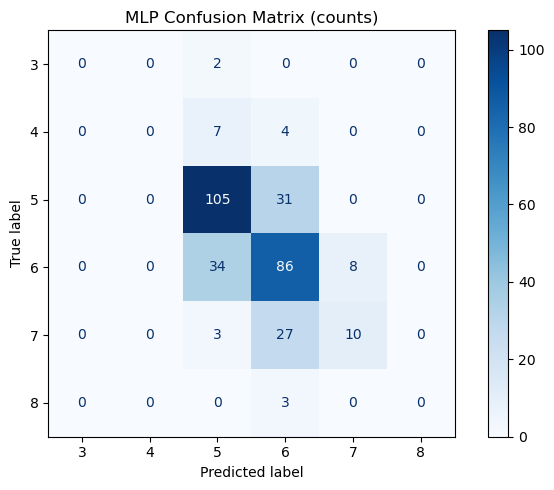

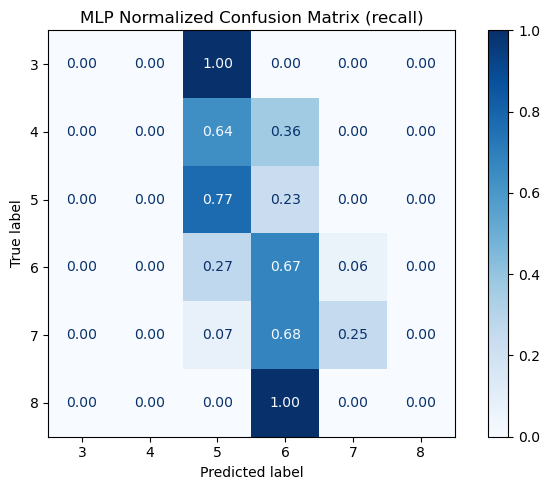

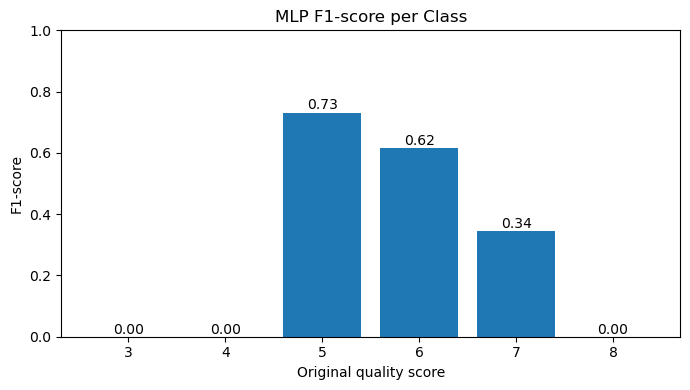

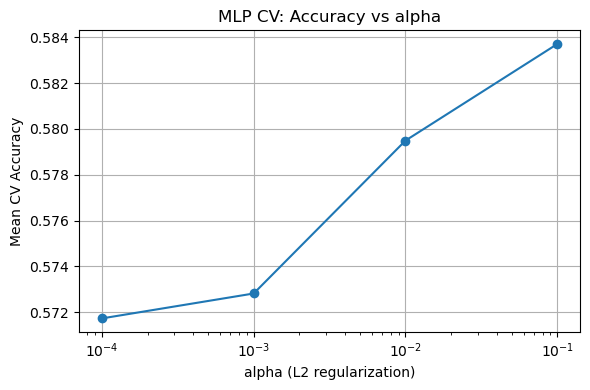

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.neural_network import MLPClassifier


df = pd.read_csv("winequality-red.csv", sep=";", engine="python", quotechar='"')

X = df.drop(["quality"], axis=1)
Y = df["quality"]

labels = sorted(df["quality"].unique())  

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=5, stratify=Y
)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        max_iter=2000,
        random_state=42,
        early_stopping=True
    ))
])

param_grid = {
    "mlp__hidden_layer_sizes": [(50,), (100,), (100, 50), (150, 100)],
    "mlp__activation": ["relu", "tanh", "logistic"],
    "mlp__alpha": [0.0001, 0.001, 0.01, 0.1],
    "mlp__learning_rate_init": [0.001, 0.01, 0.1]
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, Y_train)

print("\n=== GridSearch finished ===")
print("Best CV score:", grid.best_score_)
print("Best params:", grid.best_params_)

best = grid.best_estimator_


Y_pred = best.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
print(f"\nTest Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(
    Y_test, Y_pred,
    labels=labels,
    digits=3,
    zero_division=0
))

cm = confusion_matrix(Y_test, Y_pred, labels=labels)
print("Confusion matrix (counts):\n", cm)

plt.figure(figsize=(7, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format="d", ax=plt.gca())
plt.title("MLP Confusion Matrix (counts)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

cm_norm = confusion_matrix(Y_test, Y_pred, labels=labels, normalize="true")
plt.figure(figsize=(7, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
disp.plot(cmap="Blues", values_format=".2f", ax=plt.gca())
plt.title("MLP Normalized Confusion Matrix (recall)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

report = classification_report(
    Y_test, Y_pred,
    labels=labels,
    output_dict=True,
    zero_division=0
)

f1_scores = [report[str(l)]["f1-score"] if str(l) in report else 0.0 for l in labels]

plt.figure(figsize=(7, 4))
plt.bar([str(l) for l in labels], f1_scores)
plt.ylim(0, 1)
plt.xlabel("Original quality score")
plt.ylabel("F1-score")
plt.title("MLP F1-score per Class")
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center")
plt.tight_layout()
plt.show()

results = grid.cv_results_
alpha_vals = sorted(set(results["param_mlp__alpha"].data))
mean_scores = []
for a in alpha_vals:
    mask = results["param_mlp__alpha"].data == a
    mean_scores.append(np.mean(results["mean_test_score"][mask]))

plt.figure(figsize=(6, 4))
plt.plot(alpha_vals, mean_scores, marker="o")
plt.xscale("log")
plt.xlabel("alpha (L2 regularization)")
plt.ylabel("Mean CV Accuracy")
plt.title("MLP CV: Accuracy vs alpha")
plt.grid(True)
plt.tight_layout()
plt.show()
